In [2]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras import backend as kb
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
mu = 0.1
sigma = 0.5
steps = 100
S0 = 1
n = 100000
K = 1
epochs = 10

In [4]:
def BlackScholes(S0,r,sigma,T,K):
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    d2 = d1 - sigma * np.sqrt(T)
    return norm.cdf(d1) * S0 - norm.cdf(d2) * K * np.exp(-r*T)
callprice = BlackScholes(S0,0,sigma,1,K)
def BlackScholesCallDelta(S0,r,sigma,T,K):
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    return norm.cdf(d1)

In [5]:
xi = npr.normal(0,np.sqrt(1/steps),(n,steps))
W = np.apply_along_axis(np.cumsum,1,xi)
W = np.concatenate((np.zeros((n,1)),W),1)
drift = np.linspace(0,mu,steps+1)
drift = np.reshape(drift,(1,steps+1))
drift = np.repeat(drift,n,axis=0)
S = S0 * np.exp(drift + sigma * W)
dS = np.diff(S,1,1)
tim = np.linspace(0,1,steps+1)

In [6]:
tSinput = []
for i in range(steps):
    timv = np.repeat(tim[i],n)
    timv = np.reshape(timv,(n,1))
    Sv = np.reshape(S[:,i],(n,1))
    tSinput.append(np.concatenate((timv,Sv),1))

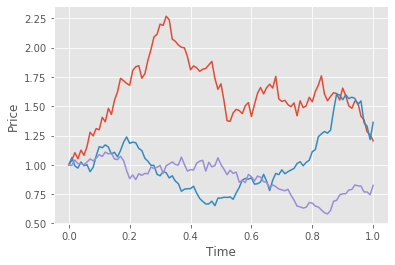

In [7]:
plt.plot(tim,S[0],tim,S[1],tim,S[2])
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [8]:
def loss_call(y_true,y_pred):
    return (callprice + kb.sum(y_pred * y_true,axis=-1) - kb.maximum(S0 + kb.sum(y_true,axis=-1) - K,0.))**2

inputs = []
predictions = []

layer1 = Dense(100, activation='relu')
layer2 = Dense(100, activation='relu')
layer3 = Dense(100, activation='relu')
layer4 = Dense(1, activation='sigmoid')

for i in range(steps):
    sinput = Input(shape=(2,))
    x = layer1(sinput)
    x = layer2(x)
    x = layer3(x)
    sprediction = layer4(x)
    inputs.append(sinput)
    predictions.append(sprediction)
    
predictions = Concatenate(axis=-1)(predictions)
model = Model(inputs=inputs, outputs=predictions)
model.summary()
model.compile(optimizer='adam', loss=loss_call, metrics=[])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2)            0                                            
____________________________________________________________________________________________

In [9]:
model.fit(tSinput,dS,batch_size=100,epochs=epochs)

Epoch 1/10
100000/100000 [==============================] - 21s 208us/step - loss: 0.0015
Epoch 2/10
100000/100000 [==============================] - 25s 249us/step - loss: 3.3937e-04
Epoch 3/10
100000/100000 [==============================] - 25s 250us/step - loss: 3.2984e-04
Epoch 4/10
100000/100000 [==============================] - 26s 257us/step - loss: 3.2495e-04
Epoch 5/10
100000/100000 [==============================] - 26s 255us/step - loss: 3.2169e-04
Epoch 6/10
100000/100000 [==============================] - 26s 256us/step - loss: 3.2409e-04
Epoch 7/10
100000/100000 [==============================] - 26s 256us/step - loss: 3.1695e-04
Epoch 8/10
100000/100000 [==============================] - 26s 258us/step - loss: 3.1689e-04
Epoch 9/10
100000/100000 [==============================] - 28s 279us/step - loss: 3.1685e-04
Epoch 10/10
100000/100000 [==============================] - 30s 300us/step - loss: 3.1571e-04


/home/ppl/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


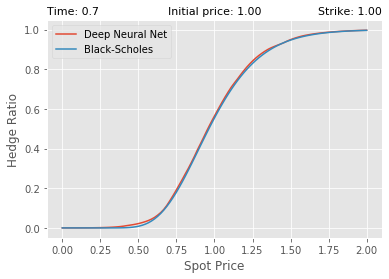

In [12]:
time = 0.7
tStest = []
Sval = np.linspace(0,2,num=steps)
for i in range(steps):
    z = (time,Sval[i])
    z = np.reshape(z,(1,2))
    tStest.append(z)

    
    
Delta_learn = np.reshape(model.predict(tStest),(steps,))
Delta_BS = BlackScholesCallDelta(Sval,0,sigma,1-time,K)
line_learn = plt.plot(Sval,Delta_learn,label="Deep Neural Net")
line_BS = plt.plot(Sval,Delta_BS, label="Black-Scholes")
plt.xlabel("Spot Price")
plt.ylabel("Hedge Ratio")
plt.title(r'Time: %1.1f' % time, loc='left', fontsize=11)
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.title(r'Initial price: %1.2f' % S0, loc='center', fontsize=11)
plt.legend()
#plt.show()
#plt.savefig("deephedge.png", dpi=150)
plt.savefig("deephedge.pdf")